# Reference Data

In [138]:
import pandas as pd
Ref=pd.read_csv('Ref.csv')
Ref["CO"] = 1000 * Ref["CO"]
Ref['Date'] = pd.to_datetime(Ref['Date_Time'])
Ref=Ref.set_index('Date')
Ref.drop('Date_Time',axis = 1, inplace = True)
Ref=Ref.resample('5min').mean()
Ref=Ref[76463:137376]

In [139]:
Ref_CO=Ref['CO'].to_list()
Ref_NO2=Ref['NO2'].to_list()
Ref_SO2=Ref['SO2'].to_list()
Ref_O3=Ref['O3'].to_list()

# CO DATA

In [150]:
import random
import pandas as pd
import scipy.io
import numpy as np
data = pd.read_csv('CO.txt', header = None,low_memory=False)
data.columns=['WE','AE','Temp','RH','Time']
Time=data['Time'].to_list()
time=[]
for i in range(len(Time)):
    time.append(float(abs(Time[i])))
Time=np.array(time)
Date=pd.to_datetime(Time-719529,unit='d').round('s')
data['Date'] = Date.tolist()
data=data.set_index('Date')
data.drop('Time',axis = 1, inplace = True)
data=data.resample('5min').mean()
Data_CO=data
Data_CO['Ref']=Ref_CO
WE=Data_CO['WE'].to_list()
AE=Data_CO['AE'].to_list()
signal=np.array(WE)-np.array(AE)
Data_CO['Net Signal']=signal
Lab=[random.randint(200,1800) for i in range(Ref.shape[0])]
Data_CO['Lab1']=Lab
Data_CO['Month']=Data_CO.index.month
Data_CO['Day_of_week']=Data_CO.index.dayofweek
Data_CO['Day']=Data_CO.index.day
Data_CO['Hour']=Data_CO.index.hour
CO_Data=Data_CO
CO_Data=CO_Data[(CO_Data[CO_Data.columns] >= 0).all(axis=1)]
CO_Data=CO_Data.dropna() 
CO_Data.head()

,WE,AE,Temp,RH,Ref,Net Signal,Lab1,Month,Day_of_week,Day,Hour
Date,,,,,,,,,,,
2019-10-10 00:00:00,392.034683,339.190266,21.248222,79.362389,176.918267,52.844418,438,10,3,10,0
2019-10-10 00:05:00,390.594672,339.582500,21.250287,79.447932,162.943200,51.012172,1738,10,3,10,0
2019-10-10 00:15:00,387.038180,339.829106,21.201875,79.608125,161.517550,47.209074,1578,10,3,10,0
2019-10-10 00:20:00,388.694572,339.828444,21.153335,79.679358,148.941867,48.866128,494,10,3,10,0
2019-10-10 00:25:00,386.747476,339.956983,21.087582,79.734711,140.227950,46.790493,830,10,3,10,0


## Model 1: Linear Regression

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae
import sklearn.metrics as sm
import matplotlib.pyplot as plt
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
#'Ref_NO2','Ref_SO2','Ref_O3',
#,'Month','Day_of_week','Day','Hour'

X=CO_Data[['Net Signal','Temp','RH','Month','Day_of_week','Day','Hour']]
y=CO_Data['Ref']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
len(y_test)

7367

In [149]:
lr = LinearRegression()
model = lr.fit(X_train, y_train)
pred = model.predict(X_test)
#lab1=X_test['Lab1'].to_list()

index=[i for i in range(len(y_test))]
Y_test=y_test.to_list()
Y_test=pd.Series(Y_test,index =index)
Y_test
Pred=pd.Series(pred,index =index)
#Lab1=pd.Series(lab1,index =index)
sMAPE_lr=round(smape_loss(Y_test,Pred),2)
#sMAPE_lab=round (smape_loss(Y_test,Lab1),2)
RMSE_lr=round(np.sqrt(sm.mean_squared_error(y_test, pred)),1)
#RMSE_lab=round(np.sqrt(sm.mean_squared_error(y_test, lab1)),1)
Pearson_lr=round(np.corrcoef(y_test, pred)[0, 1],2)
#Pearson_lab=round(np.corrcoef(y_test, lab1)[0, 1],2)
sMAPE_lr_CO=sMAPE_lr
RMSE_lr_CO=round(RMSE_lr/np.mean(np.array(y_test)),2)
Pearson_lr_CO=Pearson_lr
#sMAPE_lab_CO=sMAPE_lab
#RMSE_lab_CO=round(RMSE_lab/np.mean(np.array(lab1)),2)
#Pearson_lab_CO=Pearson_lab
R2_lr_CO=round(sm.r2_score(y_test, pred), 2)
#R2_lab_CO=round(sm.r2_score(y_test, lab1), 2)
RMSE_Lr_CO=RMSE_lr
#RMSE_Lab_CO=RMSE_lab

A=len(y_test)-100
D=max(y_test[A:])-0.2*max(y_test[A:])
C=max(y_test[A:])-0.1*max(y_test[A:])
B=120
Pearson_lr,RMSE_Lr_CO

(0.79, 264.4)

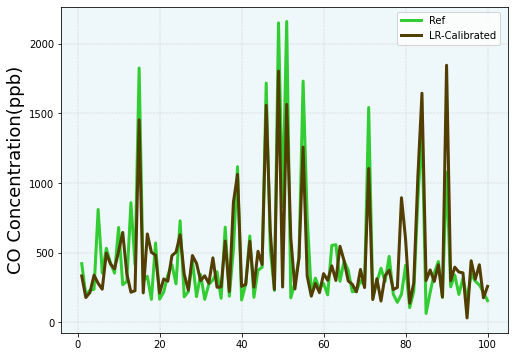

In [147]:
fig= plt.figure(figsize=(8,6))
index=[i for i in range(1,101)]
ax = fig.add_subplot(111)
ax.patch.set_facecolor('lightblue')
ax.patch.set_alpha(0.2)
plt.plot(index,y_test[A:], color='limegreen',linewidth=3)
plt.plot(index,pred[A:], color='#513e00',linewidth=3)
#plt.plot(index,lab1[A:], color='#426eff',linewidth=3)
plt.legend(['Ref', 'LR-Calibrated'], loc = 2, bbox_to_anchor = (0.74,1))
plt.ylabel('CO Concentration(ppb)',fontsize=18)
#plt.text(B-20, C, r'$R^{2}(LR)=$'+str(R2_lr_CO), fontsize = 14, color='#513e00')
#plt.text(B-20, D, r'$R^{2}(Lab)=$' +str(R2_lab_CO), fontsize = 14, color='#426eff')
#plt.text(B-70, C, 'Pearson r(LR)='+str(Pearson_lr), fontsize = 14, color='#513e00')
#plt.text(B-70, D, 'Pearson r(Lab)='+str(Pearson_lab), fontsize = 14, color='#426eff')
#plt.xlabel('Last 200 hours of testing period',fontsize=18)
#plt.title('Visualization: Linear Regression Calibration vs Laboratory Calibration',fontsize=18)
plt.grid(linestyle='-.',linewidth=0.3)
plt.show()

# NO2 DATA

In [132]:
import pandas as pd
import scipy.io
import numpy as np
data = pd.read_csv('NO2.txt', header = None,low_memory=False)
data.columns=['WE','AE','Temp','RH','Time']
Time=data['Time'].to_list()
time=[]
for i in range(len(Time)):
    time.append(float(abs(Time[i])))
Time=np.array(time)
Date=pd.to_datetime(Time-719529,unit='d').round('s')
data['Date'] = Date.tolist()
data=data.set_index('Date')
data.drop('Time',axis = 1, inplace = True)
data=data.resample('5min').mean()
Data_NO2=data
Data_NO2['Ref']=Ref_NO2
WE=Data_NO2['WE'].to_list()
AE=Data_NO2['AE'].to_list()
signal=np.array(WE)-np.array(AE)
Data_NO2['Net Signal']=signal
Data_NO2['Month']=Data_NO2.index.month
Data_NO2['Day_of_week']=Data_NO2.index.dayofweek
Data_NO2['Day']=Data_NO2.index.day
Data_NO2['Hour']=Data_NO2.index.hour
NO2_Data=Data_NO2
NO2_Data=NO2_Data[(NO2_Data[NO2_Data.columns] >= 0).all(axis=1)]
NO2_Data=NO2_Data.dropna() 
NO2_Data.shape

(37638, 10)

# SO2 DATA

In [133]:
import pandas as pd
import scipy.io
import numpy as np
data = pd.read_csv('SO2.txt', header = None,low_memory=False)
data.columns=['WE','AE','Temp','RH','Time']
Time=data['Time'].to_list()
time=[]
for i in range(len(Time)):
    time.append(float(abs(Time[i])))
Time=np.array(time)
Date=pd.to_datetime(Time-719529,unit='d').round('s')
data['Date'] = Date.tolist()
data=data.set_index('Date')
data.drop('Time',axis = 1, inplace = True)
data=data.resample('5min').mean()
Data_SO2=data
Data_SO2['Ref']=Ref_SO2
WE=Data_SO2['WE'].to_list()
AE=Data_SO2['AE'].to_list()
signal=np.array(WE)-np.array(AE)
Data_SO2['Net Signal']=signal
Data_SO2['Month']=Data_SO2.index.month
Data_SO2['Day_of_week']=Data_SO2.index.dayofweek
Data_SO2['Day']=Data_SO2.index.day
Data_SO2['Hour']=Data_SO2.index.hour
SO2_Data=Data_SO2
SO2_Data=SO2_Data[(SO2_Data[SO2_Data.columns] >= 0).all(axis=1)]
SO2_Data=SO2_Data.dropna() 


(17935, 10)

# O3 DATA

In [135]:
import pandas as pd
import scipy.io
import numpy as np
data = pd.read_csv('O3.txt', header = None,low_memory=False)
data.columns=['AE','WE','Temp','RH','Time']
Time=data['Time'].to_list()
time=[]
for i in range(len(Time)):
    time.append(float(abs(Time[i])))
Time=np.array(time)
Date=pd.to_datetime(Time-719529,unit='d').round('s')
data['Date'] = Date.tolist()
data=data.set_index('Date')
data.drop('Time',axis = 1, inplace = True)
data=data.resample('5min').mean()
Data_O3=data
Data_O3['Ref']=Ref_O3
WE=Data_O3['WE'].to_list()
AE=Data_O3['AE'].to_list()
signal=np.array(WE)-np.array(AE)
Data_O3['Net Signal']=signal
Data_O3['Month']=Data_O3.index.month
Data_O3['Day_of_week']=Data_O3.index.dayofweek
Data_O3['Day']=Data_O3.index.day
Data_O3['Hour']=Data_O3.index.hour
O3_Data=Data_O3
O3_Data=O3_Data[(O3_Data[O3_Data.columns] >= 0).all(axis=1)]
O3_Data=O3_Data.dropna() 
O3_Data.shape

(33860, 10)